In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/CSE_237D/experiment

/content/drive/My Drive/CSE_237D/experiment


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import os
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Cropping2D, ELU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from datetime import datetime
from time import time
import tifffile as tif

In [ ]:
def get_data(image_paths,label_paths):
 

  X = []
  Y = []
  for i,image in tqdm(enumerate(image_paths)):
    img = load_img(image)
    annt = load_img(label_paths[i],color_mode='grayscale')
    img.thumbnail((image_width, image_height))
    annt.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img) 
    y = img_to_array(annt) 

    x = x.reshape((256,256,3))
    y = y.reshape((256,256,1))

    x = x.astype('float32')
    x /=255.0   #normalize
    y/=255.0    #the labels are now 0,1   (the image has black and white pixels)
    y = y.astype('int32')
    X.append(x)
    Y.append(y)
  return np.asarray(X),np.asarray(Y)




def get_supervised_data(image_paths,label_paths,number_of_supervised_samples):
  sup_data_per_class = int(number_of_supervised_samples/2)
  imagepaths = []
  labelpaths = []
  count_mangrove = 0
  count_nonmangrove = 0
  for i,img_path in enumerate(image_paths):
    img = Image.open( label_paths[i] )
    img.load()
    data = np.asarray( img, dtype="int32" )
    if 1 in data and count_mangrove <= sup_data_per_class:
      count_mangrove+=1
      imagepaths.append(img_path)
      labelpaths.append(label_paths[i])
    elif count_nonmangrove <= sup_data_per_class:
      count_nonmangrove+=1
      imagepaths.append(img_path)
      labelpaths.append(label_paths[i])
  print("supervised data : ", labelpaths)
  return get_data(imagepaths,labelpaths)




In [ ]:
image_width, image_height = 256, 256

images_root = 'dataset_256px/training/images'
labels_root = 'dataset_256px/training/annotations'
image_paths = glob.glob('dataset_256px/training/images/*.jpg')   #This is random
label_paths = [ img.replace(images_root, labels_root).replace('image','annotation') for img in image_paths  ]
    
train_image_paths = image_paths[:int(0.8 * len(image_paths))]
train_label_paths = label_paths[:int(0.8 * len(image_paths))]
val_label_paths =  label_paths[int(0.8 * len(image_paths))+1 : ]
val_image_paths = image_paths[int(0.8 * len(image_paths))+1 : ] 

test_image_paths = image_paths[:]
test_label_paths = label_paths[:]



print("Total data available(tiles of 256x256) : ",len(image_paths))
num_labelled_tiles = int(0.1 * len(image_paths))
x_train, y_train = get_supervised_data (train_image_paths,train_label_paths,num_labelled_tiles)
x_valid, y_valid = get_data(val_image_paths,val_label_paths)
x_test, y_test = get_data(test_image_paths,test_label_paths)
x_unlabelled,_ = get_data(train_image_paths,train_label_paths)
print("Shape of labelled data available for training : ", x_train.shape ," and", y_train.shape)
print("Shape of labelled data available for validation : ", x_valid.shape ," and", y_valid.shape)
print("Shape of labelled data available for testing : ", x_test.shape ," and", y_test.shape)
print("Shape of unlabelled data available for training : ", x_unlabelled.shape )


Total data available(tiles of 256x256) :  2316


25it [00:00, 243.94it/s]

supervised data :  ['dataset/training/annotations/annotation_1236.jpg', 'dataset/training/annotations/annotation_1170.jpg', 'dataset/training/annotations/annotation_1197.jpg', 'dataset/training/annotations/annotation_1302.jpg', 'dataset/training/annotations/annotation_1229.jpg', 'dataset/training/annotations/annotation_1187.jpg', 'dataset/training/annotations/annotation_1158.jpg', 'dataset/training/annotations/annotation_1298.jpg', 'dataset/training/annotations/annotation_1108.jpg', 'dataset/training/annotations/annotation_1252.jpg', 'dataset/training/annotations/annotation_989.jpg', 'dataset/training/annotations/annotation_1341.jpg', 'dataset/training/annotations/annotation_1018.jpg', 'dataset/training/annotations/annotation_1250.jpg', 'dataset/training/annotations/annotation_1175.jpg', 'dataset/training/annotations/annotation_1052.jpg', 'dataset/training/annotations/annotation_995.jpg', 'dataset/training/annotations/annotation_1261.jpg', 'dataset/training/annotations/annotation_1056.

232it [00:01, 231.16it/s]
463it [00:02, 230.65it/s]
2316it [00:10, 226.59it/s]
1852it [00:07, 242.04it/s]


Shape of labelled data available for training :  (232, 256, 256, 3)  and (232, 256, 256, 1)
Shape of labelled data available for validation :  (463, 256, 256, 3)  and (463, 256, 256, 1)
Shape of labelled data available for testing :  (2316, 256, 256, 3)  and (2316, 256, 256, 1)
Shape of unlabelled data available for training :  (1852, 256, 256, 3)


In [ ]:
def jaccard_coef(y_true, y_pred, smooth=1e-12):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 0.65, 0.95):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# **UNET BASELINE WITH LESS LABELLED DATA**

In [ ]:
def U_Net_Seg_Baseline(img_shape):
    
    inputs = Input(img_shape)
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    
    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    
    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = Conv2DTranspose(128, 2, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = Conv2DTranspose(32, 2, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(conv9)
    conv9 = BatchNormalization()(conv9) 
    conv9 = ELU()(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, 
                  outputs=conv10)
    return model

In [ ]:
# # Setup saving of tensorboard files and model checkpoints
models = []
time_stamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
save_file_baseline = 'u-net-baseline-model-{}'.format(time_stamp)

models.append('final_weights/{}.h5'.format(save_file_baseline))
checkpointer = ModelCheckpoint(models[0], verbose=1, save_best_only=True)

# Save the log files for tensorboard with a timestamp of the date then the time
tensorboard_cb = TensorBoard(log_dir='final_logs/{}'.format(save_file_baseline))

In [ ]:
'''
Monitor loss -> check validation loss, once it starts diverging we are overfitting
The jaccard_coef should get larger
mean_iou should also get larger
accuracy isn't that important, but look at it anyway
'''

model_seg_baseline = U_Net_Seg_Baseline(img_shape=x_train.shape[1:])

model_seg_baseline.compile(optimizer='adam', 
                          loss='binary_crossentropy', 
                          metrics=['accuracy', 
                                   jaccard_coef, 
                                   mean_iou, 
                                   dice_coef])

model_seg_baseline.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
elu_19 (ELU)                    (None, 256, 256, 32) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [ ]:

#fitting the model with the labelled training data
model_seg_baseline.fit(x_train, y_train, 
                      batch_size=10, 
                      epochs=60, 
                      verbose=1, 
                      shuffle=False, 
                      validation_data=(x_valid, y_valid),
                      callbacks=[checkpointer, tensorboard_cb])

Train on 232 samples, validate on 463 samples
Epoch 1/60
232/232 [==============================] - 6s 25ms/step - loss: 0.4697 - accuracy: 0.8018 - jaccard_coef: 0.4135 - mean_iou: 0.3175 - dice_coef: 0.5741 - val_loss: 9.1165 - val_accuracy: 0.4035 - val_jaccard_coef: 0.2450 - val_mean_iou: 0.3338 - val_dice_coef: 0.3790

Epoch 00001: val_loss improved from 2068.46578 to 9.11651, saving model to final_weights/u-net-baseline-model-20200703-113608.h5

Epoch 2/60
232/232 [==============================] - 6s 25ms/step - loss: 0.4671 - accuracy: 0.7973 - jaccard_coef: 0.4066 - mean_iou: 0.3391 - dice_coef: 0.5686 - val_loss: 0.5211 - val_accuracy: 0.7541 - val_jaccard_coef: 0.1603 - val_mean_iou: 0.3752 - val_dice_coef: 0.2728

Epoch 00002: val_loss improved from 9.11651 to 0.52109, saving model to final_weights/u-net-baseline-model-20200703-113608.h5
Epoch 3/60
232/232 [==============================] - 6s 25ms/step - loss: 0.4322 - accuracy: 0.8238 - jaccard_coef: 0.4299 - mean_iou: 0.

In [ ]:
 
    x.show()
    y = Image.fromarray(y_data[img_index,:,:], 'L')
    y.show()
    p = Image.fromarray(predicted_masks[img_index,:,:], 'L')
    p.show()


In [ ]:

from google.colab.patches import cv2_imshow
%matplotlib inline
def plot_predictions(x_data, y_data, model, img_index=0, CUTOFF=0.5):
    predicted_masks = model.predict(x_data)

    tif.imshow(x_data[img_index, :, :, :])
    tif.imshow(y_data[img_index, :, :, :])
    tif.imshow(predicted_masks[img_index, :, :, :] > CUTOFF)
    
    plt.show()

#PLOT 4 IMAGES 48,49,59,89
visualize_image_paths = [os.path.join(images_root,"image_48.jpg"),os.path.join(images_root,"image_49.jpg"),os.path.join(images_root,"image_59.jpg"),os.path.join(images_root,"image_89.jpg")]
visualize_label_paths = [os.path.join(labels_root,"annotation_48.jpg"),os.path.join(labels_root,"annotation_49.jpg"),os.path.join(labels_root,"annotation_59.jpg"),os.path.join(labels_root,"annotation_89.jpg")]
print("Displaying the predictions for some images... \n",visualize_image_paths)
x,y = get_data(visualize_image_paths,visualize_label_paths)
plot_predictions(x, y, model_seg_baseline, img_index=2)

NameError: ignored

# **UNET AUTOENCODER**

In [ ]:
#divide the unlabelled images into taining, validation and testing for the autoencoder.
x_unlabelled_train = x_unlabelled[:int(0.8*len(x_unlabelled))]
x_unlabelled_valid = x_unlabelled[int(0.8*len(x_unlabelled))+1:]
print("Unlabelled Train Shape: ", x_unlabelled_train.shape)
print("Unlabelled Validation Shape: ", x_unlabelled_valid.shape)
                                       




Unlabelled Train Shape:  (1481, 256, 256, 3)
Unlabelled Validation Shape:  (370, 256, 256, 3)


In [ ]:
def U_Net_AutoEncoder(img_shape):
    
    inputs = Input(img_shape)
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    
    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    
    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = Conv2DTranspose(128, 2, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = Conv2DTranspose(32, 2, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(conv9)
    conv9 = BatchNormalization()(conv9) 
    conv9 = ELU()(conv9)
    
    # Note the differences in output layer: 3 channels instead of 1
    conv10 = Conv2D(3, 1, activation='linear')(conv9) 
    
    model = Model(inputs=inputs, 
                  outputs=conv10)

    return model

In [ ]:
model_ae = U_Net_AutoEncoder(img_shape=x_unlabelled_train.shape[1:])

model_ae.compile(optimizer=Adam(lr=1e-3), 
                 # Use the MSE loss function for the autoencoder
                 loss='mse', 
                 metrics=['accuracy'])

model_ae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 256, 256, 32) 128         conv2d_39[0][0]                  
__________________________________________________________________________________________________
elu_37 (ELU)                    (None, 256, 256, 32) 0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [ ]:
# Setup saving of tensorboard files and model checkpoints
models = []
time_stamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
save_file_ae = 'autoencoder-unsupervised-linear-activ-{}'.format(time_stamp)

models.append('final_weights/{}.h5'.format(save_file_ae))
checkpointer = ModelCheckpoint(models[0], verbose=1, monitor='val_loss', save_best_only=True)

# Save the log files for tensorboard with a timestamp of the date then the time
tensorboard_cb = TensorBoard(log_dir='final_logs/{}'.format(save_file_ae))

In [ ]:
# For full unalbelled train set   
model_ae.fit(x_unlabelled_train, x_unlabelled_train, 
                  batch_size=32, 
                  epochs=45, 
                  verbose=1, 
                  shuffle=True, 
                  validation_data=(x_unlabelled_valid, x_unlabelled_valid),
                  callbacks=[checkpointer, tensorboard_cb])

Train on 1481 samples, validate on 370 samples
Epoch 1/45
1481/1481 [==============================] - 26s 18ms/step - loss: 0.1707 - accuracy: 0.4182 - val_loss: 11.2186 - val_accuracy: 0.3162

Epoch 00001: val_loss improved from inf to 11.21860, saving model to final_weights/autoencoder-unsupervised-linear-activ-20200703-124725.h5
Epoch 2/45
1481/1481 [==============================] - 20s 13ms/step - loss: 0.0108 - accuracy: 0.5931 - val_loss: 0.1787 - val_accuracy: 0.3711

Epoch 00002: val_loss improved from 11.21860 to 0.17873, saving model to final_weights/autoencoder-unsupervised-linear-activ-20200703-124725.h5
Epoch 3/45
1481/1481 [==============================] - 20s 13ms/step - loss: 0.0067 - accuracy: 0.6504 - val_loss: 0.0474 - val_accuracy: 0.4216

Epoch 00003: val_loss improved from 0.17873 to 0.04740, saving model to final_weights/autoencoder-unsupervised-linear-activ-20200703-124725.h5
Epoch 4/45
1481/1481 [==============================] - 20s 13ms/step - loss: 0.0043

First image is the original, second is the reconstructed image


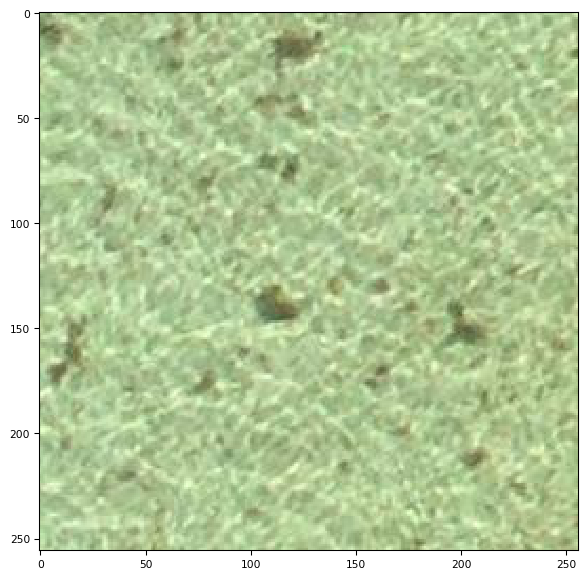

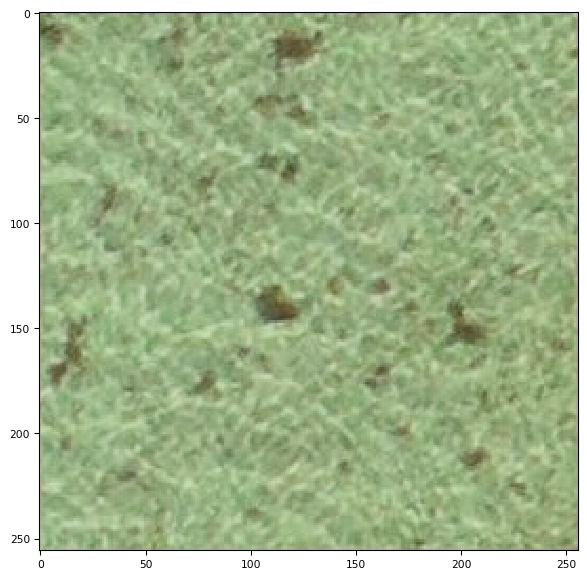

In [ ]:
%matplotlib inline
def plot_reconstructions(x_data, y_data, model, img_index=0):
    predicted_masks = model.predict(x_data)
    
    print("First image is the original, second is the reconstructed image")
    tif.imshow(x_data[img_index, :, :, :])
    
    tif.imshow(predicted_masks[img_index, :, :, :] / np.amax(predicted_masks))
    
    plt.show()

# Try plotting predictions on training data
plot_reconstructions(x_unlabelled_train, x_unlabelled_train, model_ae, img_index=2)

In [ ]:
'''
setting up the model to use weights from the autoencoder for fine tuning (semi supervised) 
'''
def U_Net_Seg_Transfer(base_model, base_model_weights_path):
    
    # Load the weights from the autoencoder 
    base_model.load_weights(base_model_weights_path, by_name=True)
    
    # Get the output of the layer before the last conv layer
    out_base = base_model.layers[-1].output
    
    # Add on the last conv layer for segmentation
    conv_last = Conv2D(1, 1, activation='sigmoid')(out_base)
    
    # Define the inputs and outputs
    model = Model(inputs=base_model.inputs, 
                  outputs=conv_last)

    return model

In [ ]:
'''
In this example I am training the last 6 layers (see two cells below)
I tried training only the last layer that we added and this did not work (but I only ran it for 15 epochs, so it could be I needed to run it longer)
We need to try training more layers, or re-train all the layers (just use the pre-training as an initialization)
'''

save_path = 'final_weights/{}.h5'.format(save_file_ae)

#save_path = 'weights/{}.h5'.format('autoencoder-full-dstl-model-20180602-181822')
# Pass in the path we saved the weights file too as well as the model
model_segmentation = U_Net_Seg_Transfer(model_ae, save_path)

# Printout all the layer names and whether or not they are set to be trained 
for layer in model_segmentation.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe32bd449e8> False
<keras.layers.convolutional.Conv2D object at 0x7fe32c861d30> True
<keras.layers.normalization.BatchNormalization object at 0x7fe32c861e80> True
<keras.layers.advanced_activations.ELU object at 0x7fe32c2fd518> True
<keras.layers.convolutional.Conv2D object at 0x7fe32de53cc0> True
<keras.layers.normalization.BatchNormalization object at 0x7fe32bccaba8> True
<keras.layers.advanced_activations.ELU object at 0x7fe3296d2780> True
<keras.layers.pooling.MaxPooling2D object at 0x7fe3296da1d0> True
<keras.layers.convolutional.Conv2D object at 0x7fe32c15fac8> True
<keras.layers.normalization.BatchNormalization object at 0x7fe32c15c710> True
<keras.layers.advanced_activations.ELU object at 0x7fe32c15ca58> True
<keras.layers.convolutional.Conv2D object at 0x7fe33107d9e8> True
<keras.layers.normalization.BatchNormalization object at 0x7fe331054860> True
<keras.layers.advanced_activations.ELU object at 0x7fe331045f28> True
<keras.la

In [ ]:
# When we load in the weights, those layers get set to False (will not be trained)
# We need to change this if we wish to train them
# Set a certain number of layers to train
# -> can see how many layers there are by using: len(model_segmentation.layers)

# Training all the layers works best
for layer in model_segmentation.layers:
        layer.trainable = True

# Printout all the layer names and whether or not they are set to be trained 
for layer in model_segmentation.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe32bd449e8> True
<keras.layers.convolutional.Conv2D object at 0x7fe32c861d30> True
<keras.layers.normalization.BatchNormalization object at 0x7fe32c861e80> True
<keras.layers.advanced_activations.ELU object at 0x7fe32c2fd518> True
<keras.layers.convolutional.Conv2D object at 0x7fe32de53cc0> True
<keras.layers.normalization.BatchNormalization object at 0x7fe32bccaba8> True
<keras.layers.advanced_activations.ELU object at 0x7fe3296d2780> True
<keras.layers.pooling.MaxPooling2D object at 0x7fe3296da1d0> True
<keras.layers.convolutional.Conv2D object at 0x7fe32c15fac8> True
<keras.layers.normalization.BatchNormalization object at 0x7fe32c15c710> True
<keras.layers.advanced_activations.ELU object at 0x7fe32c15ca58> True
<keras.layers.convolutional.Conv2D object at 0x7fe33107d9e8> True
<keras.layers.normalization.BatchNormalization object at 0x7fe331054860> True
<keras.layers.advanced_activations.ELU object at 0x7fe331045f28> True
<keras.lay

In [ ]:
model_segmentation.compile(optimizer=Adam(lr=1e-3), 
                          loss='binary_crossentropy', 
                          metrics=['accuracy', 
                               jaccard_coef, 
                               mean_iou, 
                               dice_coef])


        
model_segmentation.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 256, 256, 32) 128         conv2d_39[0][0]                  
__________________________________________________________________________________________________
elu_37 (ELU)                    (None, 256, 256, 32) 0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [ ]:
# Setup saving of tensorboard files and model checkpoints
models = []
time_stamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
save_file_finetune = 'finetune-unet-alllayers-final{}'.format(time_stamp)

models.append('final_weights/{}.h5'.format(save_file_finetune))
checkpointer = ModelCheckpoint(models[0], verbose=1, monitor='val_loss', save_best_only=True)

# Save the log files for tensorboard with a timestamp of the date then the time
tensorboard_cb = TensorBoard(log_dir='final_logs/{}'.format(save_file_finetune))

In [ ]:
# Train
model_segmentation.fit(x_train, y_train, 
                      batch_size=8, 
                      epochs=60, 
                      verbose=1, 
                      shuffle=False, 
                      validation_data=(x_valid, y_valid),
                      callbacks=[checkpointer, tensorboard_cb])

Train on 232 samples, validate on 463 samples
Epoch 1/60
232/232 [==============================] - 11s 48ms/step - loss: 0.4713 - accuracy: 0.8105 - jaccard_coef: 0.3737 - mean_iou: 0.5909 - dice_coef: 0.5274 - val_loss: 0.5329 - val_accuracy: 0.8046 - val_jaccard_coef: 0.4316 - val_mean_iou: 0.6357 - val_dice_coef: 0.5710

Epoch 00001: val_loss improved from inf to 0.53295, saving model to final_weights/finetune-unet-alllayers-final20200703-130619.h5
Epoch 2/60
232/232 [==============================] - 6s 27ms/step - loss: 0.4429 - accuracy: 0.8135 - jaccard_coef: 0.4013 - mean_iou: 0.6397 - dice_coef: 0.5575 - val_loss: 0.4285 - val_accuracy: 0.8720 - val_jaccard_coef: 0.4459 - val_mean_iou: 0.6473 - val_dice_coef: 0.5908

Epoch 00002: val_loss improved from 0.53295 to 0.42846, saving model to final_weights/finetune-unet-alllayers-final20200703-130619.h5
Epoch 3/60
232/232 [==============================] - 6s 27ms/step - loss: 0.4363 - accuracy: 0.8168 - jaccard_coef: 0.4048 - mea

In [ ]:
#plot here